<div style='float: right'><img src='pic/nurikabe.png'/></div>

## <div id='nurikabe' />ぬりかべ

In [1]:
#!pip3 install pulp ortoolpy
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt
from itertools import groupby, product
from pulp import LpProblem, LpMaximize, lpDot, lpSum, value
from ortoolpy import addvar, addvars, addbinvar, addbinvars, unionfind
data = """\
.3...1.
.......
2..1...
.......
.1..2..
..2....
1...1.6""".split('\n')
nw, nh = len(data[0]), len(data)

### 問題
* 盤面のいくつかのマスを黒くぬります
* 数字は、黒マスによって分断されたシマのマスの数を表します
* すべてのシマに数字がちょうど１つずつ入ります
* 数字が入っているマスを黒くぬってはいけません
* すべての黒マスはタテヨコにひとつながりになります
* 黒マスを２×２以上のカタマリにしてはいけません

### 考え方
* 高速に解くために黒マスの数を最大化します

### 変数
* vb：0:white, 1:black (1)
* 島ごとに可能な候補を作ります
  * vt (2)

### 制約
* 黒マスを２×２以上のカタマリ禁止 (3)
* 候補から1つ選びます (4)
* 候補を選んだらそのマスは白マスで周りは黒マス (5)
* 黒マスが連結していること (6)

CPU times: user 4.27 ms, sys: 4.02 ms, total: 8.29 ms
Wall time: 26 ms
CPU times: user 6.32 ms, sys: 4.62 ms, total: 10.9 ms
Wall time: 29 ms


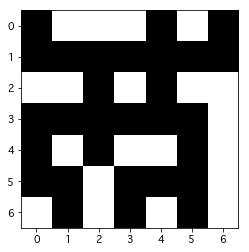

In [2]:
m = LpProblem(sense=LpMaximize)
vb = np.array(addbinvars(nh, nw)) # 0:white, 1:black (1)
m += lpSum(vb.flat) # obj func
def dirs(i, j):
    return [(i+x-y, j+x+y-1) for y in range(2) for x in range(2)
        if 0 <= i+x-y < nh and 0 <= j+x+y-1 < nw]
def make(lst, i, j, n, w):
    if len(w) == n:
        lst.append(w)
        return
    for a, b in dirs(i, j):
        if (a,b) not in w and all([(c,d) == w[0] or data[c][d] == '.' for c,d in dirs(a, b)]):
            make(lst, a, b, n, w + [(a,b)])
for i, j in product(range(nh), range(nw)):
    if i < nh-1 and j < nw-1:
        m += lpSum(vb[i:i+2,j:j+2]) <= 3 # (3)
    if data[i][j] == '.':
        continue
    lst = []
    make(lst, i, j, int(data[i][j]), [(i,j)])
    lst = [u[0] for u in groupby(lst)]
    vt = addbinvars(len(lst)) # (2)
    m += lpSum(vt) == 1 # (4)
    for k, w in enumerate(lst):
        bd = list(set([(c,d) for a, b in w for c, d in dirs(a, b) if (c,d) not in w]))
        m += (lpSum(vb[y,x] for y,x in w) + len(bd) - lpSum(vb[y,x] for y,x in bd) <=
              (len(w)+len(bd)) * (1-vt[k])) # (5)
while True:
    %time m.solve()
    rb = np.vectorize(value)(vb)
    if unionfind.isconnected(rb):
        break
    m += lpSum(vb[rb==0]) >= 1 # (6)
plt.imshow(1-rb, cmap='gray', interpolation='none');